In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df =  pd.read_csv('/content/drive/MyDrive/Content Moderation/clean_data.csv')
df.head()

,tweet,clean_tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain clean hous man alway t...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat coldtyga dwn bad cuffin dat hoe 1st place,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya,1


In [6]:
from wordcloud import WordCloud

In [7]:
def generat_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [8]:
list(df[df['label']==0].tweet)[:5]

["!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...",
 '" momma said no pussy cats inside my doghouse "',
 '"@Addicted2Guys: -SimplyAddictedToGuys http://t.co/1jL4hi8ZMF" woof woof hot scally lad',
 '"@AllAboutManFeet: http://t.co/3gzUpfuMev" woof woof and hot soles',
 '"@Allyhaaaaa: Lemmie eat a Oreo &amp; do these dishes." One oreo? Lol']

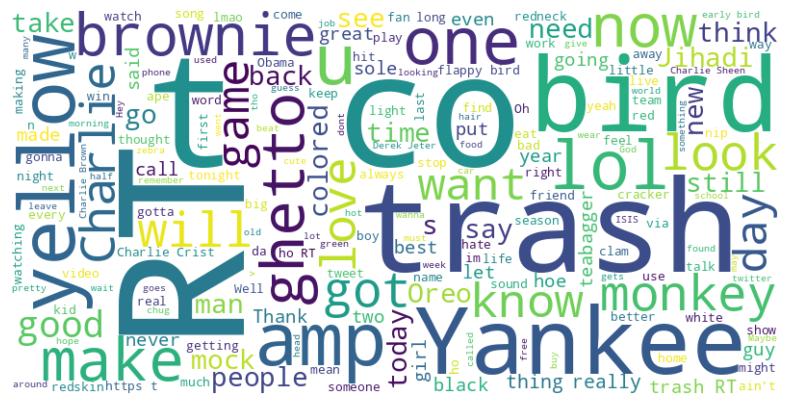

In [9]:
# Word Cloud for Appropriate Tweets (Raw)
generat_word_cloud(' '.join(list(df[df['label']==0].tweet)))

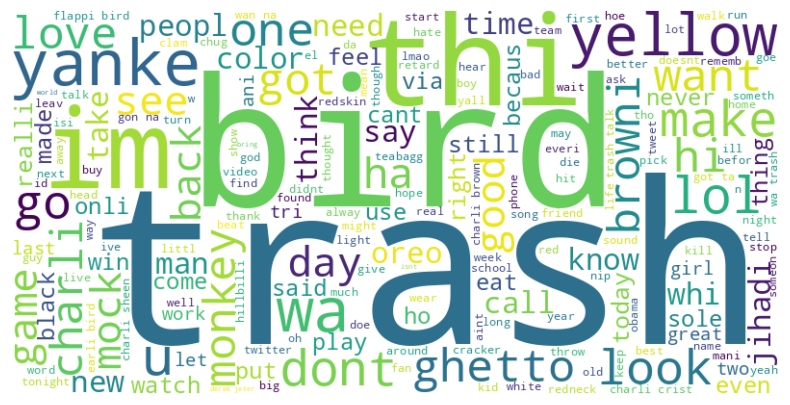

In [10]:
# Word Cloud for Appropriate Tweets (Pre-processed)
cl_tw = df[df['label'] == 0]['clean_tweet'].fillna('').astype(str)
generat_word_cloud(' '.join(cl_tw))

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        24783 non-null  object
 1   clean_tweet  24781 non-null  object
 2   label        24783 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 581.0+ KB


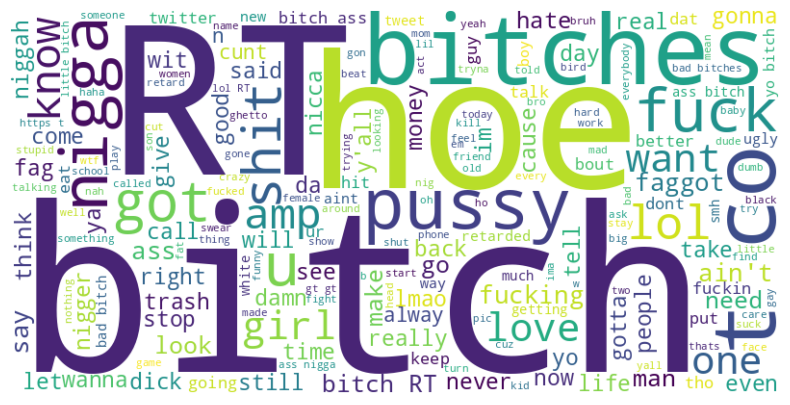

In [12]:
# Word Cloud for Inappropriate Tweets (Raw)
generat_word_cloud(' '.join(list(df[df['label']==1].tweet)))

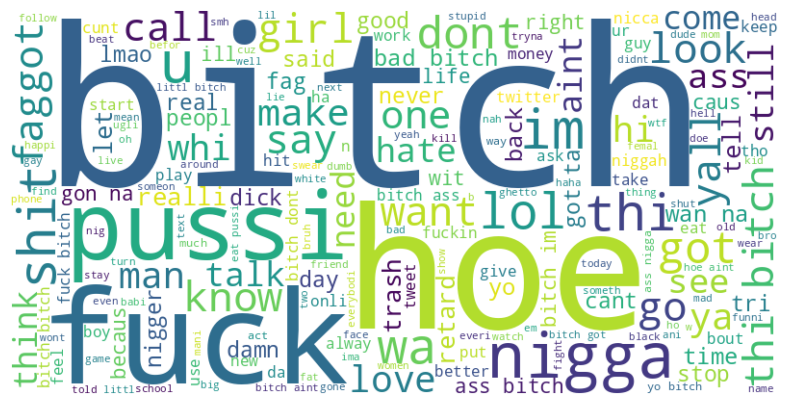

In [13]:
# Word Cloud for Inappropriate Tweets (Pre-processed)
cl_tw = df[df['label'] == 1]['clean_tweet'].fillna('').astype(str)
generat_word_cloud(' '.join(cl_tw))

In [14]:
df['label'].value_counts()

,count
label,
1,20620
0,4163


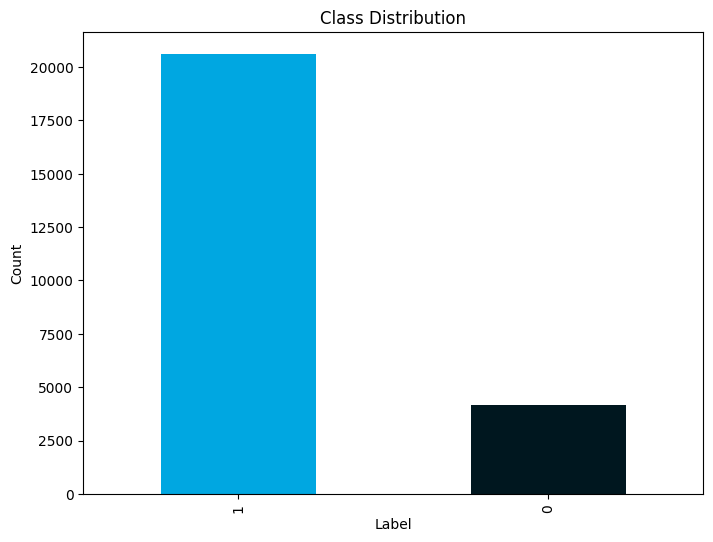

In [18]:
c_distribution = df['label'].value_counts()
plt.figure(figsize=(8, 6))
c_distribution.plot(kind='bar', color=['#00A7E1', '#00171F', 'red'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [24]:
from collections import Counter
words =  df['clean_tweet'].astype(str).apply(lambda x: [word for word in x.split()])

In [25]:
# most common words in the dataset (general)
words = [word for sublist in words for word in sublist]
word_count = Counter(words)
word_count.most_common(20)

[('bitch', 11334),
 ('hoe', 4277),
 ('like', 2855),
 ('fuck', 2250),
 ('pussi', 2215),
 ('thi', 2158),
 ('im', 2088),
 ('nigga', 1990),
 ('dont', 1784),
 ('get', 1776),
 ('got', 1609),
 ('ass', 1586),
 ('shit', 1291),
 ('u', 1282),
 ('aint', 1169),
 ('wa', 1157),
 ('trash', 1153),
 ('lol', 1067),
 ('go', 903),
 ('know', 880)]

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

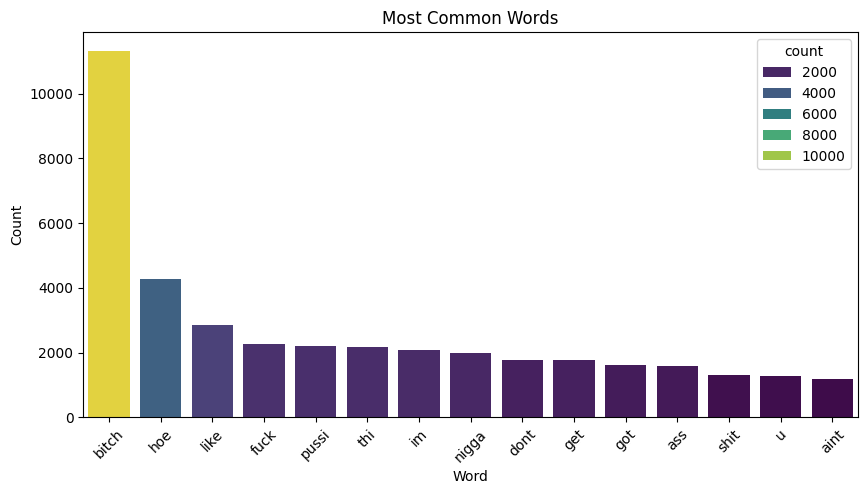

In [33]:
w_c_df =  pd.DataFrame(word_count.most_common(15), columns=['word', 'count'])
plt.figure(figsize=(10, 5))
sns.barplot(x='word', y='count', data=w_c_df,hue='count', palette='viridis')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Common Words')
plt.xticks(rotation=45)
plt.show()

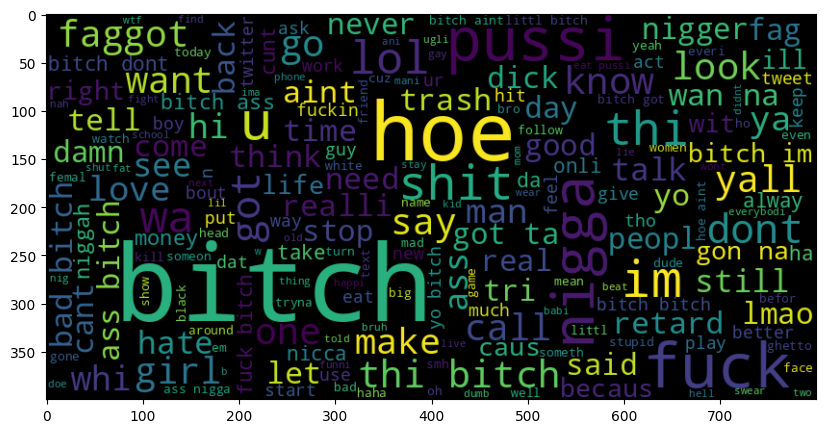

In [40]:
neutral = df[df['label'] == 1]['clean_tweet']
neutral_words = neutral.astype(str).apply(lambda x: [word for word in x.split()])

neutral_words = [word for sublist in neutral_words for word in sublist]
neutral_word_count = Counter(neutral_words)
neutral_word_count.most_common(20)

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(' '.join(neutral_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')

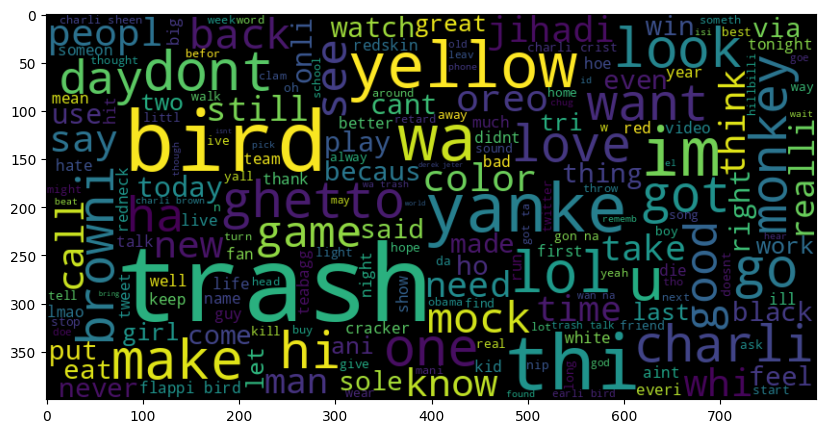

In [42]:
neutral = df[df['label'] == 0]['clean_tweet']
neutral_words = neutral.astype(str).apply(lambda x: [word for word in x.split()])

neutral_words = [word for sublist in neutral_words for word in sublist]
neutral_word_count = Counter(neutral_words)
neutral_word_count.most_common(20)

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(' '.join(neutral_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

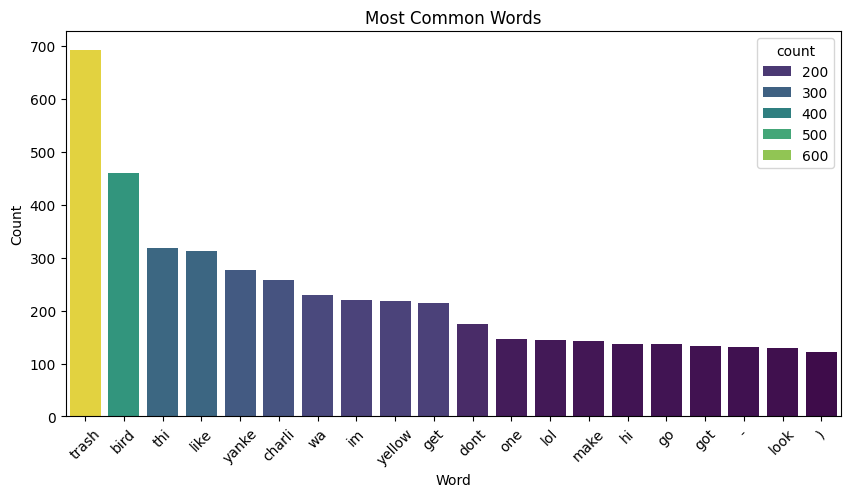

In [44]:
nwc_df = pd.DataFrame(neutral_word_count.most_common(20), columns=['word', 'count'])

plt.figure(figsize=(10, 5))
sns.barplot(x='word', y='count', data=nwc_df, hue='count', palette='viridis')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Common Words')
plt.xticks(rotation=45)
plt.show()